<a href="https://colab.research.google.com/drive/19UVBnX2RyDhXzDnRyqxAwAr5B-csH01t?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Market Basket Linkedin Analysis**
**Finding frequent itemsets in LinkedIn Jobs & Skills dataset**


Import libraries

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=92e22e311735557e700531161da682c4df0d6b6712dfe37a8a668ec1b1782c5e
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark
import zipfile
import string
import nltk
from pyspark import SparkContext
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col, collect_list,  size

Download the dataset from Kaggle

In [3]:
# Insert your own Username and Key

os.environ['KAGGLE_USERNAME'] = "xxxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxx"
!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024

100% 1.87G/1.88G [00:25<00:00, 123MB/s]
100% 1.88G/1.88G [00:25<00:00, 77.7MB/s]


In [4]:
# Unzip
import zipfile

with zipfile.ZipFile('/content/1-3m-linkedin-jobs-and-skills-2024.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

Inizialize PySpark session

In [5]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

**Analysis and Preprocessing**

In [6]:
skill_data = spark.read.csv('/content/job_skills.csv', header=True, inferSchema=True, sep=",")

In [7]:
skill_data = skill_data.dropna()
skill_df = skill_data.select('job_skills')

In [8]:
# Just for computations
skill_dff = skill_data.withColumn('job_skills_list', split(skill_data['job_skills'], ','))

In [9]:
skill_dff = skill_dff.withColumn('num_skills', size(skill_dff['job_skills_list']))

In [10]:
# average, minimum and maximum number of skills required

average_num_skills = skill_dff.agg({'num_skills': 'avg'}).collect()[0][0]
max_skills = skill_dff.agg({'num_skills': 'max'}).collect()[0][0]
min_skills = skill_dff.agg({'num_skills': 'min'}).collect()[0][0]
print(f"Average number of skills per job: {average_num_skills}")
print(f"Maximum number of skills per job: {max_skills}")
print(f"Minimum number of skills per job: {min_skills}")

Average number of skills per job: 20.789084144149992
Maximum number of skills per job: 463
Minimum number of skills per job: 1


In [11]:
# take sample of the data for computational reasons

subset = skill_df.sample(False, 0.01, seed=42)

In [12]:
rdd = subset.rdd.map(lambda x: x[0])

In [13]:
rdd.getNumPartitions()

6

In [14]:
# N. of baskets
subset.count()

13057

Preprocess the skills

In [15]:
nltk.download('punkt')
nltk.download('wordnet')
def preprocess(data):
    # Convert everything to lowercase
    text = data.lower()

    # Tokenize by splitting on commas
    skills_list = text.split(',')

    # Remove eventual punctuation
    skills_list = [skill.translate(str.maketrans('', '', string.punctuation)) for skill in skills_list]

    # Remove eventual whitespaces
    skills_list = [skill.strip() for skill in skills_list]

    return skills_list


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [16]:
rdd = rdd.map(preprocess)

In [17]:
# threshold set to be 2% of the baskets
p = 0.02
threshold = int(rdd.count()*p)
print(f"Support threshold of {p*100}% of the baskets: {threshold} baskets.")

Support threshold of 0.02 of the baskets: 261 baskets.


Hashing skills to integers for space efficienty

In [18]:
# Function to create utils and the dictionary

def create_dictionary(rdd):

    # indexing the skills
    integer2skill = rdd.flatMap(lambda line:line)\
                      .distinct().zipWithIndex()\
                      .map(lambda x: (x[1], x[0]))\
                      .collectAsMap()

    # reverse
    skill2integer = {value:key for key, value in integer2skill.items()}

    return integer2skill, skill2integer

In [19]:
# Create the dictionaries for converting and reconverting
integer2skill, skill2integer = create_dictionary(rdd)

In [20]:
# Function for hashing
def hashing(rdd, vocab):
 return rdd.map(lambda basket: [vocab[skill] for skill in basket])

In [21]:
# Hashing the skills
rdd = hashing(rdd, skill2integer)

# **A-Priori algorithm implementation**

In [22]:
results = []

In [23]:
# First Pass

frequent_singletons = rdd.flatMap(lambda basket: [(skill, 1) for skill in basket])\
        .reduceByKey(lambda t1, t2: t1+t2)\
        .filter(lambda t: t[1]>threshold)

print(f"Number of frequent singletons: {frequent_singletons.count()}")

Number of frequent singletons: 83


In [24]:
results += frequent_singletons.collect()

In [25]:
# Take only the skills removing the count
frequent_singletons = frequent_singletons.map(lambda t: t[0])

In [26]:
# Create candidates for next pass

candidates = frequent_singletons.cartesian(frequent_singletons)\
                                .filter(lambda t: len(set(t))==len(t))\
                                .map(lambda t: tuple(sorted(t)))\
                                .distinct()\
                                .collect()

In [27]:
# Second Pass

frequent_pairs = rdd.flatMap(lambda basket: [(tuple(candidate), 1) for candidate in candidates if set(candidate).issubset(set(basket))])\
                    .reduceByKey(lambda t1,t2: t1+t2)\
                    .filter(lambda t: t[1]>threshold)

print(f"Number of frequent pairs: {frequent_pairs.count()}")

Number of frequent pairs: 69


In [28]:
results += frequent_pairs.collect()
frequent_pairs = frequent_pairs.map(lambda t: t[0])

In [29]:
candidates = frequent_pairs.cartesian(frequent_pairs)\
                          .map(lambda tuples: {item for tupla in tuples for item in tupla})\
                          .filter(lambda t: len(t) == 3)\
                          .map(lambda t: tuple(sorted(t)))\
                          .distinct()\
                          .collect()

In [30]:
# Third Pass

frequent_triples = rdd.flatMap(lambda basket: [(tuple(candidate), 1) for candidate in candidates if set(candidate).issubset(set(basket))])\
                    .reduceByKey(lambda t1,t2: t1+t2)\
                    .filter(lambda t: t[1]>threshold)

print(f"Number of frequent triples: {frequent_triples.count()}")

Number of frequent triples: 22


In [31]:
results += frequent_triples.collect()
frequent_triples = frequent_triples.map(lambda t: t[0])

In [32]:
candidates = frequent_triples.cartesian(frequent_triples)\
                          .map(lambda tuples: {item for tupla in tuples for item in tupla})\
                          .filter(lambda t: len(t) == 4)\
                          .map(lambda t: tuple(sorted(t)))\
                          .distinct()\
                          .collect()

In [33]:
# Fourth Pass

frequent_quad = rdd.flatMap(lambda basket: [(tuple(candidate), 1) for candidate in candidates if set(candidate).issubset(set(basket))])\
                    .reduceByKey(lambda t1,t2: t1+t2)\
                    .filter(lambda t: t[1]>threshold)

print(f"Number of frequent size-4 itemsets: {frequent_quad.count()}")

Number of frequent size-4 itemsets: 0


In [34]:
results += frequent_quad.collect()
frequent_quad = frequent_quad.map(lambda t: t[0])

In [35]:
# Re-convert the results to words

results = [(integer2skill[t[0]],t[1]) if type(t[0])==int else (tuple([integer2skill[element] for element in t[0]]),t[1]) for t in results]

In [36]:
# Most frequent itemsets sorted by count

results_sorted = sorted(results, key=lambda x: x[1], reverse=True)

for i in results_sorted:
    print(i)

('communication', 3717)
('customer service', 2796)
('teamwork', 2274)
('communication skills', 1950)
('leadership', 1845)
('problem solving', 1515)
('time management', 1408)
(('customer service', 'communication'), 1374)
(('teamwork', 'communication'), 1345)
('attention to detail', 1312)
('problemsolving', 1222)
('project management', 1183)
(('leadership', 'communication'), 1174)
('interpersonal skills', 1019)
('patient care', 1013)
(('problem solving', 'communication'), 965)
('sales', 953)
(('teamwork', 'customer service'), 915)
('collaboration', 853)
('nursing', 849)
(('communication', 'time management'), 837)
('data analysis', 829)
(('problemsolving', 'communication'), 821)
('training', 804)
('inventory management', 737)
('organizational skills', 724)
('microsoft office suite', 719)
(('customer service', 'leadership'), 684)
('high school diploma', 683)
('bachelors degree', 680)
(('customer service', 'sales'), 645)
(('attention to detail', 'communication'), 630)
('scheduling', 625)
('

**Create the APriori Function to automate the algorithm**

In [37]:
def apriori(rdd, threshold_perc=0.02, max_size = "none"): # User can choose to find itesets only until a certain size (max_size)
  # Compute the threshold
  threshold = int(rdd.count()*threshold_perc)

  # Hashing the skills
  integer2skill, skill2integer = create_dictionary(rdd)
  rdd = hashing(rdd, skill2integer)

  # Create a list for storing results and candidates
  Iterate = True

  results = []
  candidates = []

  # Compute frequent singletons
  frequent_singletons = rdd.flatMap(lambda basket: [(skill, 1) for skill in basket])\
        .reduceByKey(lambda t1, t2: t1+t2)\
        .filter(lambda t: t[1]>threshold)

  print(f"Number of frequent singletons: {frequent_singletons.count()}")

  # Add to results and remove count
  results += frequent_singletons.collect()
  frequent_singletons = frequent_singletons.map(lambda t:t[0])

  # Compute candidates for next iteration
  candidates = frequent_singletons.cartesian(frequent_singletons)\
                                .filter(lambda t: len(set(t))==len(t))\
                                .map(lambda t: tuple(sorted(t)))\
                                .distinct()\
                                .collect()

  # Define the candidate size, starting from triples
  candidate_size = 3

  while Iterate:

    # If we are just interested in singletons -> exit the loop
    if max_size ==1:
      break

    # Filtering
    frequent_k_itemset = rdd.flatMap(lambda basket: [(tuple(candidate), 1) for candidate in candidates if set(candidate).issubset(set(basket))])\
                    .reduceByKey(lambda t1,t2: t1+t2)\
                    .filter(lambda t: t[1]>threshold)

    print(f"Number of frequent {candidate_size-1}-size itemsets: {frequent_k_itemset.count()}")

    # Add to results and remove count
    results += frequent_k_itemset.collect()
    frequent_k_itemset = frequent_k_itemset.map(lambda t:t[0])

    # Compute candidates for the next iteration
    candidates = frequent_k_itemset.cartesian(frequent_k_itemset)\
                          .map(lambda tuples: {item for tupla in tuples for item in tupla})\
                          .filter(lambda t: len(t) == candidate_size)\
                          .map(lambda t: tuple(sorted(t)))\
                          .distinct()\
                          .collect()

    # Iterate until the candidate set is empty or the max itemset size (max_size) has been reached
    if ((max_size=="none") and (len(candidates) == 0)) or ((max_size != "none") and (candidate_size-1 == max_size)):
      Iterate = False

    candidate_size += 1

  return [(integer2skill[t[0]],t[1]) if type(t[0])==int else (tuple([integer2skill[element] for element in t[0]]),t[1]) for t in results]


In [38]:
# Run the algorithm and show the results

resultsf = apriori(rdd, 0.02)

resultsf = [(integer2skill[t[0]],t[1]) if type(t[0])==int else (tuple([integer2skill[element] for element in t[0]]),t[1]) for t in resultsf]
results_sortedf = sorted(resultsf, key=lambda x: x[1], reverse=True)
print()
print("Frequent Itemsets sorted by occurences:")
for i in results_sortedf:
    print(i)

Number of frequent singletons: 83
Number of frequent 2-size itemsets: 69
Number of frequent 3-size itemsets: 22
Number of frequent 4-size itemsets: 0

Frequent Itemsets sorted by occurences:
('communication', 3717)
('customer service', 2796)
('teamwork', 2274)
('communication skills', 1950)
('leadership', 1845)
('problem solving', 1515)
('time management', 1408)
(('customer service', 'communication'), 1374)
(('communication', 'teamwork'), 1345)
('attention to detail', 1312)
('problemsolving', 1222)
('project management', 1183)
(('leadership', 'communication'), 1174)
('interpersonal skills', 1019)
('patient care', 1013)
(('communication', 'problem solving'), 965)
('sales', 953)
(('customer service', 'teamwork'), 915)
('collaboration', 853)
('nursing', 849)
(('time management', 'communication'), 837)
('data analysis', 829)
(('communication', 'problemsolving'), 821)
('training', 804)
('inventory management', 737)
('organizational skills', 724)
('microsoft office suite', 719)
(('leadership

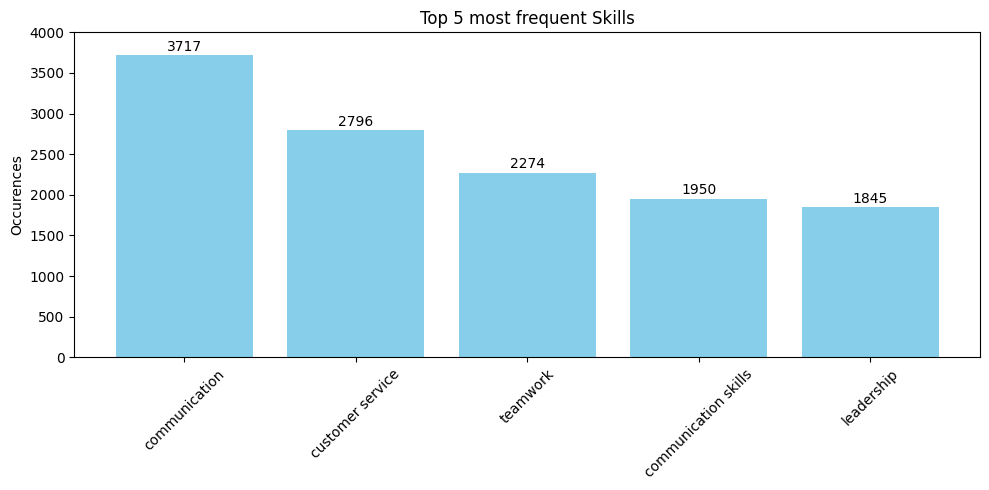

In [39]:
# Plot the results

# Extract the singletons from results
single_skills = [item[0] for item in results_sortedf[:5]]
single_counts = [item[1] for item in results_sortedf[:5]]

plt.figure(figsize=(10, 5))
bars = plt.bar(single_skills, single_counts, color='skyblue')
plt.title('Top 5 most frequent Skills')
plt.ylabel('Occurences')
plt.xticks(rotation=45)
plt.ylim(0, 4000)
for bar, count in zip(bars, single_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 20, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()

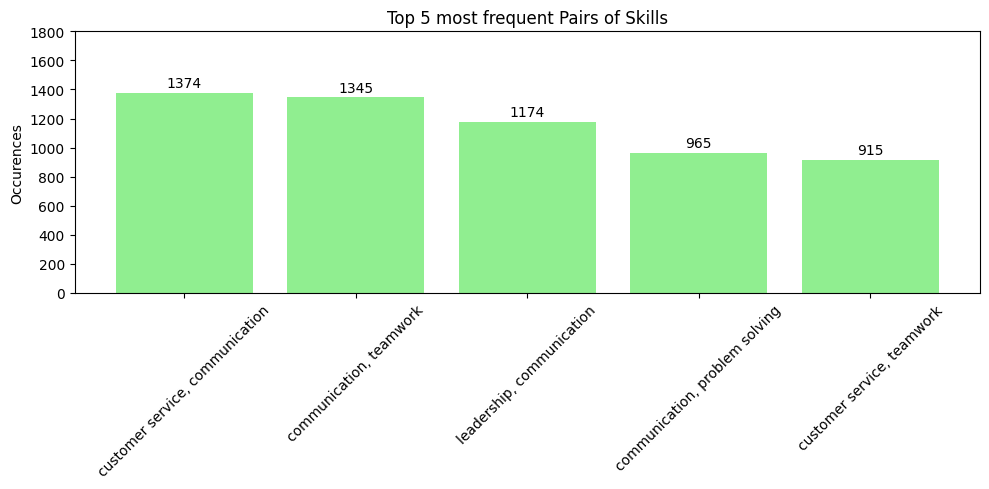

In [40]:
# Extract the pairs from results
double_skills = [item[0] for item in results_sortedf if isinstance(item[0], tuple)][:5]
double_counts = [item[1] for item in results_sortedf if isinstance(item[0], tuple)][:5]

plt.figure(figsize=(10, 5))
bars = plt.bar([', '.join(item) for item in double_skills], double_counts, color='lightgreen')
plt.title('Top 5 most frequent Pairs of Skills')
plt.ylabel('Occurences')
plt.xticks(rotation=45)
plt.ylim(0, 1800)
for bar, count in zip(bars, double_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 20, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()

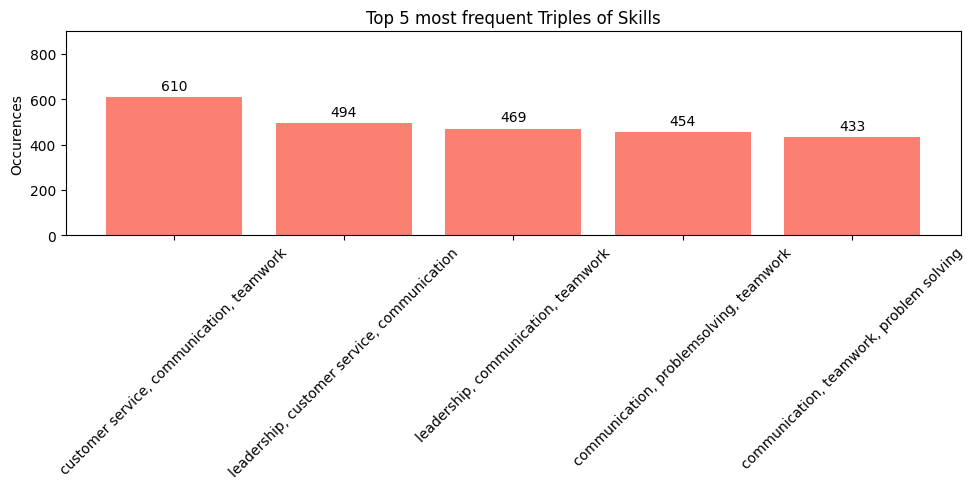

In [41]:
# Extract the triples
triple_skills = [item[0] for item in results_sortedf if isinstance(item[0], tuple) and len(item[0]) == 3][:5]
triple_counts = [item[1] for item in results_sortedf if isinstance(item[0], tuple) and len(item[0]) == 3][:5]

plt.figure(figsize=(10, 5))
bars = plt.bar([', '.join(item) for item in triple_skills], triple_counts, color='salmon')
plt.title('Top 5 most frequent Triples of Skills')
plt.ylabel('Occurences')
plt.xticks(rotation=45)
plt.ylim(0, 900)
for bar, count in zip(bars, triple_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 20, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [42]:
spark.stop()